# DLAV Project - Phase 3

In this notebook we will train a very simple planner and test its real-world performance.

In [1]:
pip install wandb

In [2]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 103.8 MB/s eta 0:00:00


In [3]:
# Log in to your W&B account
import wandb
import random
import math

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nael-darwiche (nael-darwiche-epfl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if"
output_zip = "dlav_val_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5"
output_zip = "test_public_real.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=e8bc4344-05fb-4504-b1a5-be433665766d
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:09<00:00, 45.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if
From (redirected): https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if&confirm=t&uuid=d0f842f2-8dfe-4b44-8a39-53ed0630c88b
To: /content/dlav_val_real.zip
100%|██████████| 129M/129M [00:03<00:00, 36.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5
From (redirected): https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5&confirm=t&uuid=561754c4-ff30-49b0-b692-cb0a42c37c8a
To: /content/test_public_real.zip
100%|██████████| 110M/110M [00:02<00:00, 44.5MB/s]


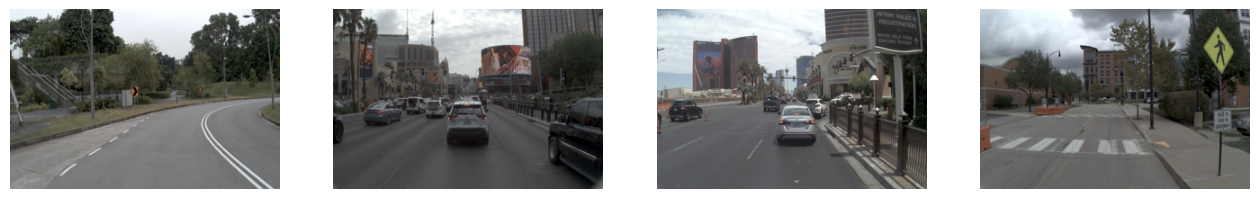

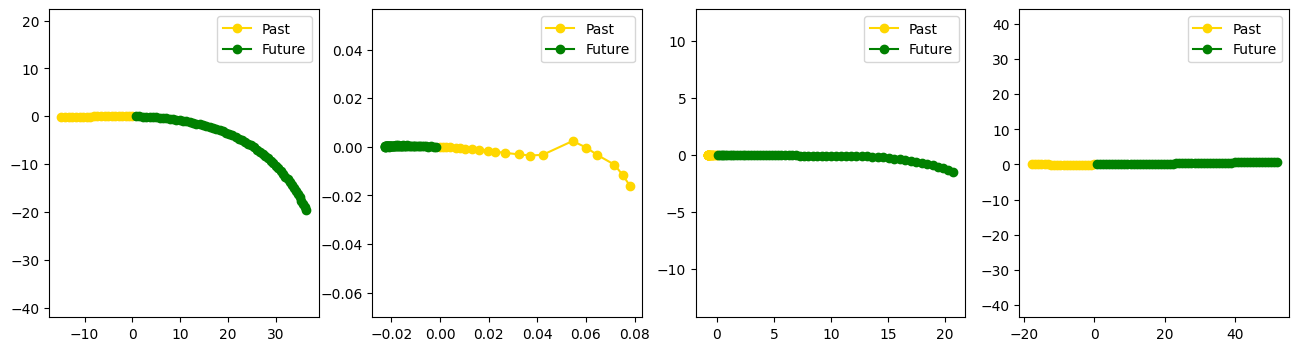

In [6]:
# Visualize the dataset


import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import os
k = 4
# load the data
# dir = "train"
dir = "val_real"
data = []
test_files = os.listdir(dir)

seed = 42

for i in range(seed, seed + k):
    with open(f"{dir}/{test_files[i]}", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now let's train the model with synthetic data and test it with the real-world data.

In [ ]:
# !pip install --upgrade --force-reinstall torch torchvision torchaudio


  Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Us

In [18]:
import os
import torch
import pickle
import numpy as np
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import InterpolationMode
import math

class DrivingDataset(Dataset):
    def __init__(self, file_list, transform=None,
                 flip_prob: float = 0.5,
                 max_rotate_deg: float = 5.0,

                 test: bool = False,
                 val: bool = False):
        self.samples        = file_list
        self.test           = test
        self.val            = val
        self.transform      = transform
        self.flip_prob      = flip_prob
        self.max_rotate_deg = max_rotate_deg

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # --- load data ---
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        img_np = data['camera']
        if img_np.dtype != np.uint8:
            img_np = (255 * img_np).clip(0,255).astype(np.uint8)
        img = Image.fromarray(img_np)

        # spatial augmentations (flip, rotate, translate)
        do_flip   = (random.random() < self.flip_prob) if not (self.test or self.val) else False
        angle     = random.uniform(-self.max_rotate_deg, self.max_rotate_deg) if not (self.test or self.val) else 0.0

        # 1) horizontal flip
        if do_flip:
            img = TF.hflip(img)

        # 2) rotation
        if angle != 0.0:
            img = TF.rotate(img, angle,
                            interpolation=InterpolationMode.BILINEAR,
                            expand=False)


        # photometric transforms
        if self.transform:
            camera = self.transform(img)
        else:
            camera = T.ToTensor()(img)

        # load trajectories
        history = torch.FloatTensor(data['sdc_history_feature'])  # [21,3]
        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])  # [60,3]

        # Flip trajectories
        if do_flip:
            # flip y-axis
            history[:,1] = -history[:,1]
            if not self.test:
                future[:,1] = -future[:,1]

        if angle != 0.0:
            theta = math.radians(angle)
            R = torch.tensor([
                [ math.cos(theta), -math.sin(theta)],
                [ math.sin(theta),  math.cos(theta)]
            ], dtype=history.dtype, device=history.device)
            history[:,1:] = history[:,1:] @ R
            if not self.test:
                future[:,1:] = future[:,1:] @ R

        if not self.test:
            return {
                'camera': camera,
                'history': history,
                'future':  future
            }
        else:
            return {
                'camera': camera,
                'history': history
            }


## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
import scipy.signal as sp

#  Depth reconstruction head
# We won't be using it for this phase
class DepthHead(nn.Module):
    def __init__(self, in_ch=512):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_ch, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128,  64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64,    1, kernel_size=1)   # Returns single channel
        )

    def forward(self, feats):
        # features (from resnet18 backbone): (B, in_ch, H, W)
        return self.decoder(feats)  # (B,1,H',W')


def feature_map_to_tokens(x):
    """
    x: (B, C, H, W)
    returns: (B, H*W, C)
    """
    B, C, H, W = x.shape
    x = x.view(B, C, H * W).permute(0, 2, 1)
    return x

class DrivingPlanner(nn.Module):
    def __init__(
        self,
        history_steps: int = 21,
        future_steps: int = 60,
        decoder_layers: int = 3,
        nhead: int = 8,
        dropout: float = 0.15,
        mlp_hidden: int = 256,
        reduced_dim: int = 384,
        use_depth_aux: bool = False
    ):
        super().__init__()
        self.future_steps = future_steps
        self.use_depth_aux = use_depth_aux

        # 1)resnet18 backbone
        backbone = resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])
        feat_dim = 512    # final conv channels
        num_patches = 7 * 7

        #2) project spatial features to reduced_dim (lighter for the transformer decoder)
        self.feature_proj = nn.Linear(feat_dim, reduced_dim)
        # positional embeddings for the 49 tokens
        self.feature_pos_embed = nn.Parameter(torch.zeros(1, num_patches, reduced_dim))
        nn.init.trunc_normal_(self.feature_pos_embed, std=0.02)

        # 3)history embeding + positional
        self.history_embed  = nn.Linear(3, reduced_dim)
        self.history_pos_embed = nn.Parameter(torch.zeros(history_steps, reduced_dim))
        nn.init.trunc_normal_(self.history_pos_embed, std=0.02)

        # 4) transformer decoder: history queries attend to vision tokens (keys and values)
        # We can also see it as the final encoder. The actual decoder is the MLP head.
        hist_layer = nn.TransformerDecoderLayer(
            d_model=reduced_dim,
            nhead=nhead,
            dim_feedforward=reduced_dim * 2,
            dropout=dropout,
            batch_first=True
        )
        self.history_decoder = nn.TransformerDecoder(hist_layer, num_layers=decoder_layers)

        #5) MLP head (final decoder)
        self.mlp = nn.Sequential(
            nn.Linear(history_steps * reduced_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(mlp_hidden, future_steps * 3)
        )

        # 6)Depth auxiliary head
        if self.use_depth_aux:
            self.depth_head = DepthHead(in_ch=feat_dim)

    def forward(self, camera: torch.Tensor, sdc_history_feature: torch.Tensor, post_processing: bool = True,
                order: int = 4, cutoff: int = 0.25):
        B = camera.size(0)

        # extract conv features and tokenize
        feats = self.encoder(camera)                        # (B,512,7,7)
        tokens = feature_map_to_tokens(feats)               # (B,49,512)
        vision_emb = self.feature_proj(tokens)              # (B,49,D)
        vision_emb = vision_emb + self.feature_pos_embed    # (B,49,D)

        # history embeding
        hist = self.history_embed(sdc_history_feature)      # (B,T, D)
        hist = hist + self.history_pos_embed.unsqueeze(0)   # (B,T, D)

        # decode history against vision tokens
        decoded = self.history_decoder(tgt=hist, memory=vision_emb)  # (B,T, D)

        # predicts the future (decoder)
        raw = self.mlp(decoded.reshape(B, -1))              # (B, T*3)
        future = raw.view(B, self.future_steps, 3)          # (B, T, 3)

        """if post_processing:
          # smoothing
          tmp = future.permute(0, 2, 1)                       # (B,3,T)
          padded = F.pad(tmp, (1,1), mode='replicate')        # (B,3,T+2)
          smoothed = F.avg_pool1d(padded, kernel_size=3, stride=1)  # (B,3,T)
          future = smoothed.permute(0, 2, 1)                  # (B,T,3)"""
        if post_processing:
          # Elliptic filter
          rp     = 0.5
          rs     = 40
          sos    = sp.ellip(order, rp, rs, cutoff, btype='low', output='sos')

          # 2) Convert to numpy and apply zero-phase filtering
          #    sosfiltfilt does its own edge-padding and returns same length
          future_np = future.detach().cpu().numpy()  # shape [B, T, 3]
          B, T, C   = future_np.shape

          for b_idx in range(B):
              for dim in range(C):
                  future_np[b_idx, :, dim] = sp.sosfiltfilt(
                      sos,
                      future_np[b_idx, :, dim]
                  )

          # 3) Convert back to torch.Tensor on the original device/dtype
          future = torch.from_numpy(future_np) \
                        .to(future.device) \
                        .type(future.dtype)

        #depth decoding
        depth_out = None
        if self.use_depth_aux:
            # small depth map from head
            depth_out = self.depth_head(feats)              # (B,1,h',w')
            # upsample to match input resolution
            depth_out = F.interpolate(
                depth_out,
                size=camera.shape[2:],
                mode='bilinear',
                align_corners=False
            )  # (B,1,H,W)

        return future, depth_out


## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [20]:
import torch
import torch.nn.functional as F
from transformers import get_cosine_schedule_with_warmup


def validate(model, val_loader, device, post_processing=False, order=4, cutoff=0.25):
    model.eval()
    total_ade, total_fde, total_mse = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for batch in val_loader:
            cam = batch['camera'].to(device)
            hist = batch['history'].to(device)
            fut = batch['future'].to(device)

            fut_pred, _ = model(cam, hist, post_processing, order, cutoff)

            B, T, _ = fut.shape
            count += B

            ade = torch.norm(fut_pred[:, :, :2] - fut[:, :, :2], dim=2).mean(dim=1).sum()
            fde = torch.norm(fut_pred[:, -1, :2] - fut[:, -1, :2], dim=1).sum()
            mse = F.mse_loss(fut_pred, fut, reduction='sum')

            total_ade += ade.item()
            total_fde += fde.item()
            total_mse += mse.item()

    ade_avg = total_ade / count
    fde_avg = total_fde / count
    mse_avg = total_mse / (count * T * 3)

    return ade_avg, fde_avg, mse_avg


def train(model, train_loader, val_loader, optimizer, num_epochs=50, use_depth_aux=False, post_processing=False, order=4,
          cutoff=0.25):
    best_val_ade = float('inf')
    patience = 51
    no_improve = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    total_steps = len(train_loader) * num_epochs
    warmup_steps = max(1, int(0.1 * total_steps))
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
        num_cycles=0.5
    )

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for idx, batch in enumerate(train_loader):
            if idx % 10 == 0:
                print(f"Epoch {epoch+1}, batch {idx}")

            cam, hist, fut = [batch[k].to(device) for k in ['camera', 'history', 'future']]
            optimizer.zero_grad()
            fut_pred, dep_pred = model(cam, hist, post_processing, order, cutoff)
            # print(f"future pred shape is {fut_pred.shape}")

            # Use ADE as the training loss
            ade_loss = torch.norm(fut_pred[:, :, :2] - fut[:, :, :2], dim=2).mean()
            loss = ade_loss
            if use_depth_aux:
                pass

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)
        ade_val, fde_val, mse_val = validate(model, val_loader, device, post_processing, order, cutoff)

        # save best model
        if ade_val < best_val_ade:
            best_val_ade = ade_val
            no_improve = 0
            torch.save(model.state_dict(), "best_model.pt")
            print(f"  new best val ADE: {ade_val:.4f}, saving model")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"early stopping: no improvement in {patience} epochs.")
                break
        # ————————————————

        print(
            f"Epoch {epoch+1}, Train ADE Loss: {avg_loss:.4f}, "
            f"Val ADE: {ade_val:.4f}, FDE: {fde_val:.4f}, Traj MSE: {mse_val:.6f}"
        )

        wandb.log({
          "train_ADE": avg_loss,
          "val_ADE": ade_val,
          "val_FDE": fde_val,
          "val_MSE": mse_val,
          "lr": optimizer.param_groups[0]["lr"]
        })

    print("Training complete.")


In [21]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os


# Set up transforms
IMG_H, IMG_W = 200, 300


train_transform = T.Compose([
    T.Resize((224, 224)),
    # No spatial transforms

    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    T.RandomGrayscale(p=0.1),

    T.RandomApply([T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.2),

    T.RandomPosterize(bits=4, p=0.1),
    T.RandomSolarize(threshold=192, p=0.1),

    T.RandomAutocontrast(p=0.1),
    T.RandomAdjustSharpness(sharpness_factor=2.0, p=0.1),

    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

train_data_dir = "train"
val_data_dir = "val_real"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_files_mixed = train_files + val_files[:500]
val_files = val_files[500:]

train_dataset = DrivingDataset(train_files_mixed, transform=train_transform, test=False, val=False)
val_dataset = DrivingDataset(val_files, transform=val_transform, test=False, val=True)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=16)

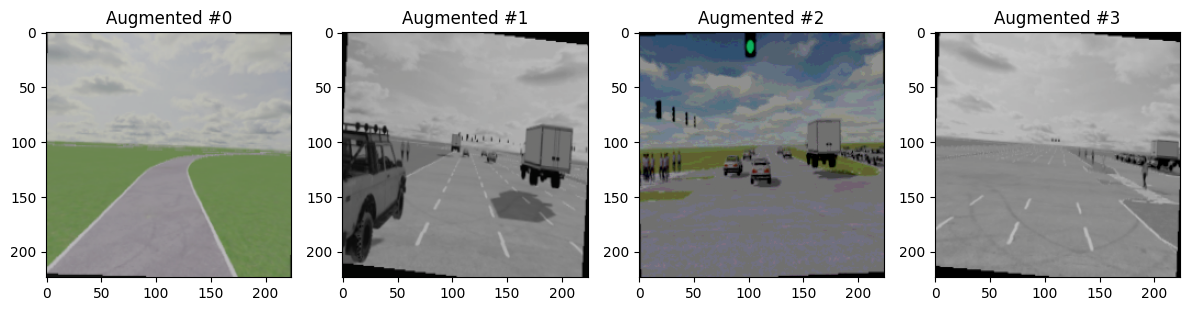

In [22]:
# VISUALIZE AUGMENTATIONS
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
import torchvision.utils as vutils

# Define a function to un-normalize and display a single image tensor
def imshow_tensor(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Creates "inverse" normalization transform : x' = (x - mean)/std --> unnormalized x'' = x' * std + mean = std*(x' + mean/std) --> std' = 1/std, and
    # mean' = -mean/std
    inv_normalize = T.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1.0/s for s in std]
    )
    img_unnorm = inv_normalize(img_tensor)                # un-normalize
    img_np = img_unnorm.permute(1, 2, 0).cpu().numpy()     # CHW -> HWC, to numpy
    img_np = np.clip(img_np, 0.0, 1.0)
    # plt.imshow(img_np)
    # plt.axis('off')
    return img_np

# Loop through a few batches and visualize augmentations
for batch_idx, batch in enumerate(train_loader):
    images = batch['camera']      # Tensor of shape [B, 3, 224, 224]

    # visualize up to 4 images from this batch
    n_to_show = min(images.size(0), 4)
    plt.figure(figsize=(12, 3))
    for i in range(n_to_show):
        plt.subplot(1, n_to_show, i+1)
        unnormalized = imshow_tensor(images[i])
        plt.imshow(unnormalized)
        plt.title(f"Augmented #{i}")
    plt.tight_layout()
    plt.show()
    break # only visualize first batch


In [23]:
wandb.init(
    project="DLAV-phase-3",
    name="vit-planner-run",
    config={
        "base_lr": 2e-4,
        "weight_decay": 0.01,
        "batch_size": train_loader.batch_size,
        "epochs": 50,
        "dropout_mlp": 0.35,
        "warmup_steps": 0.1,
        "future_GT_and_history_modified_based_on_aug": True,
        "only_ADE_loss": True,
        "aux_input": True,
        "post_processing": True,
        "dropout_transformers": 0,
        "using_resnet": True,
        "batch_size": 32
    }
)

lr,▂▄▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_ADE,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_ADE,█▄▃▃▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_FDE,█▄▃▃▂▁▂▂▁▂▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MSE,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0
train_ADE,1.51916
val_ADE,1.89268
val_FDE,4.96785
val_MSE,7.48932


## 🔍 Let's Compare Two Settings

We'll now train and evaluate the model in **two modes**:

1. **Without auxiliary task** — the model only predicts the trajectory.
2. **With depth auxiliary task** — the model also predicts a depth map, which helps it learn better visual features.

By comparing the results (ADE, FDE, and Trajectory MSE), you'll see the benefit of multi-task learning in action! 🚀

In [24]:
from torch.optim import AdamW


In [25]:
# NO AUXILIARY DEPTH MAP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_depth_aux=False
model_no_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
model_no_aux.to(device)

DrivingPlanner(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
# torch.save(model_no_aux.state_dict(), "phase1_model.pth")


In [26]:
# TRAIN
optimizer = AdamW(model_no_aux.parameters(), lr=2e-4, weight_decay=0.01)
train(model_no_aux, train_loader, val_loader, optimizer, num_epochs=50,use_depth_aux=use_depth_aux)

Using device: cuda
Epoch 1, batch 0
Epoch 1, batch 10
Epoch 1, batch 20
Epoch 1, batch 30
Epoch 1, batch 40
Epoch 1, batch 50
Epoch 1, batch 60
Epoch 1, batch 70
Epoch 1, batch 80
Epoch 1, batch 90
Epoch 1, batch 100
Epoch 1, batch 110
Epoch 1, batch 120
Epoch 1, batch 130
Epoch 1, batch 140
Epoch 1, batch 150
Epoch 1, batch 160
Epoch 1, batch 170
  new best val ADE: 8.7340, saving model
Epoch 1, Train ADE Loss: 12.8620, Val ADE: 8.7340, FDE: 28.1437, Traj MSE: 84.561652
Epoch 2, batch 0
Epoch 2, batch 10
Epoch 2, batch 20
Epoch 2, batch 30
Epoch 2, batch 40
Epoch 2, batch 50
Epoch 2, batch 60
Epoch 2, batch 70
Epoch 2, batch 80
Epoch 2, batch 90
Epoch 2, batch 100
Epoch 2, batch 110
Epoch 2, batch 120
Epoch 2, batch 130
Epoch 2, batch 140
Epoch 2, batch 150
Epoch 2, batch 160
Epoch 2, batch 170
  new best val ADE: 3.2083, saving model
Epoch 2, Train ADE Loss: 6.7838, Val ADE: 3.2083, FDE: 12.5417, Traj MSE: 20.685963
Epoch 3, batch 0
Epoch 3, batch 10
Epoch 3, batch 20
Epoch 3, batch 

In [27]:
# LOAD MODEL
model_no_aux.load_state_dict(torch.load("/content/best_model.pt"))

<All keys matched successfully>

In [28]:
# VALIDATE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ade, fde, mse = validate(model_no_aux, val_loader, device)
print(f"Validation results for model with depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

Validation results for model with depth auxiliary loss: ADE: 1.8056, FDE: 4.8762, Traj MSE: 6.294935


In [69]:
# Parameter (order and cutoff) search filter coefficients
for order in [2, 3, 4]:
  for cutoff in np.linspace(0.1, 0.4, 15):
    ade, fde, mse = validate(model_no_aux, val_loader, device, post_processing=True, order=order, cutoff=cutoff)
    print(f"Validation results for model with depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}, order: {order}, cutoff: {cutoff}")

Validation results for model with depth auxiliary loss: ADE: 2.1022, FDE: 4.8116, Traj MSE: 4.473325, order: 2, cutoff: 0.1
Validation results for model with depth auxiliary loss: ADE: 2.1067, FDE: 4.9013, Traj MSE: 4.526929, order: 2, cutoff: 0.12142857142857144
Validation results for model with depth auxiliary loss: ADE: 2.1086, FDE: 4.9547, Traj MSE: 4.576024, order: 2, cutoff: 0.14285714285714288
Validation results for model with depth auxiliary loss: ADE: 2.1092, FDE: 4.9766, Traj MSE: 4.628334, order: 2, cutoff: 0.1642857142857143
Validation results for model with depth auxiliary loss: ADE: 2.1093, FDE: 4.9795, Traj MSE: 4.683324, order: 2, cutoff: 0.18571428571428572
Validation results for model with depth auxiliary loss: ADE: 2.1092, FDE: 4.9743, Traj MSE: 4.732318, order: 2, cutoff: 0.20714285714285718
Validation results for model with depth auxiliary loss: ADE: 2.1091, FDE: 4.9680, Traj MSE: 4.769344, order: 2, cutoff: 0.2285714285714286
Validation results for model with dept

KeyboardInterrupt: 

## 🔍 Final Visualization and Comparison

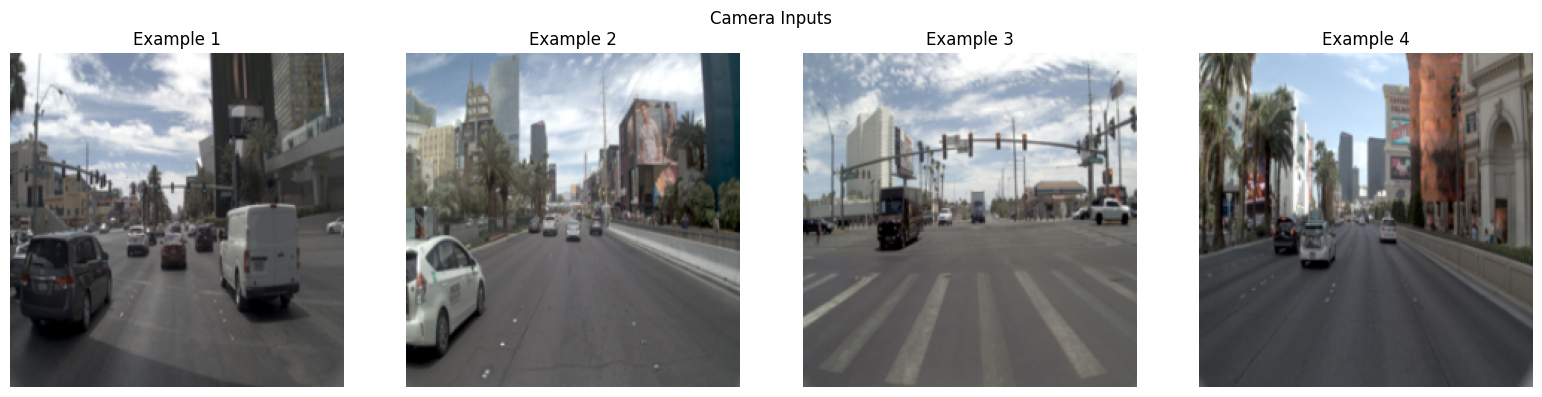

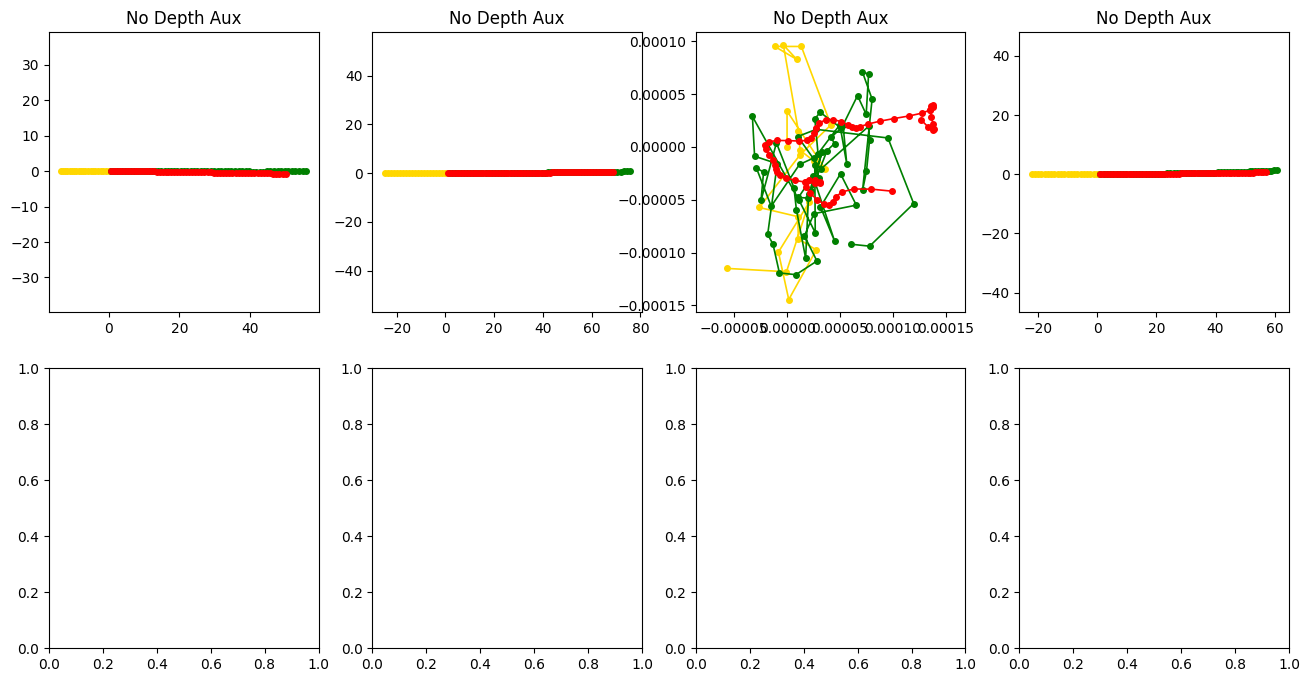

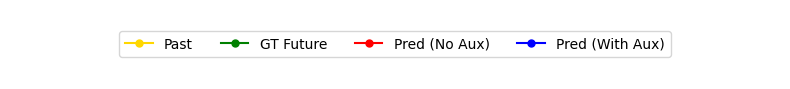

<Figure size 640x480 with 0 Axes>

In [71]:
import matplotlib.pyplot as plt
import random

random.seed(1002)

def visualize_comparison(val_loader, model_no_aux, device):
    model_no_aux.eval()
    # model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)

    with torch.no_grad():
        pred_no_aux, _ = model_no_aux(camera, history)
        # pred_with_aux, pred_depth = model_with_aux(camera, history)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_no_aux = pred_no_aux.cpu().numpy()

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        normalized = camera[idx]
        unnormalized = imshow_tensor(torch.from_numpy(normalized))
        ax[i].imshow(unnormalized)
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(2, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # Without aux
        ax[0, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[0, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[0, i].plot(pred_no_aux[idx, :, 0], pred_no_aux[idx, :, 1], 'o-', label='Pred (No Aux)', color='red', markersize=4, linewidth=1.2)
        ax[0, i].set_title("No Depth Aux")
        ax[0, i].axis("equal")


    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



# 🔚 Call at the end after training both models
visualize_comparison(val_loader, model_no_aux, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called submission_phase2.csv by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

FileNotFoundError: [Errno 2] No such file or directory: 'test_public/0.pkl'

In [ ]:
import pandas as pd
test_data_dir = "test_public_real"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, transform=val_transform, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model_no_aux.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future, _ = model_no_aux(camera, history, post_processing=True)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase3.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (864, 121)
